In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from numpy import savez_compressed
from numpy import load
import random

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import metrics
from tensorflow.keras import backend as K


from helper_functions import load_and_split_data
from helper_functions import triplet_loss_l2
from helper_functions import triplet_loss_cosine
from helper_functions import plot_triplet_roc_curve

In [3]:
cosine_similarity = metrics.CosineSimilarity()

In [4]:
%%time
train_dataset, test_dataset, val_dataset = load_and_split_data("npz_datasets/data_x_15000_rgb_triplet.npz", "npz_datasets/data_y_15000_rgb_triplet.npz", split_size=80, batch_size=128, triplet=True)

CPU times: user 1min 18s, sys: 19.1 s, total: 1min 38s
Wall time: 1min 37s


In [4]:
train_dataset.take(1)

<TakeDataset shapes: (((None, 224, 224, 3), (None, 224, 224, 3), (None, 224, 224, 3)), (None, 0)), types: ((tf.float64, tf.float64, tf.float64), tf.float64)>

# Create and Train model function

In [5]:
def create_and_train_model(base_model, emb_size, epochs, model_name):
    img_width = 224
    img_height = 224
    emb_size = emb_size
    
    base_model = base_model
    base_model.trainable = False
    
    inputs = keras.layers.Input((img_width, img_height, 3))
    x = base_model(inputs, training=False)
    x = keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.Dense(512, activation="relu")(x)
    x = keras.layers.Dense(emb_size, activation="relu")(x)
    outputs = keras.layers.Lambda(lambda x: tf.keras.backend.l2_normalize(x, axis=1))(x)

    base_model = keras.models.Model(inputs, outputs)
    
    input_anchor = keras.layers.Input(shape=(224,224,3))
    input_positive = keras.layers.Input(shape=(224,224,3))
    input_negative = keras.layers.Input(shape=(224,224,3))

    embed_anchor = base_model(input_anchor)
    embed_positive = base_model(input_positive)
    embed_negative = base_model(input_negative)

    out = keras.layers.concatenate([embed_anchor, embed_positive, embed_negative], axis=1)
    
    model = keras.models.Model([input_anchor, input_positive, input_negative], out)
    
    model.compile(loss=triplet_loss_l2(alpha=0.2, emb_size=emb_size), optimizer="Adam")
    
    history = model.fit(train_dataset, validation_data=val_dataset, epochs=epochs)
    
    plot_triplet_roc_curve(model, test_dataset, model_name, emb_size)
    
    return history, model

# VGG 16

Epoch 1/10
94/94 [==============================] - 75s 629ms/step - loss: 0.0329 - val_loss: 0.0231
Epoch 2/10
94/94 [==============================] - 39s 410ms/step - loss: 0.0196 - val_loss: 0.0251
Epoch 3/10
94/94 [==============================] - 39s 409ms/step - loss: 0.0179 - val_loss: 0.0173
Epoch 4/10
94/94 [==============================] - 39s 411ms/step - loss: 0.0139 - val_loss: 0.0170
Epoch 5/10
94/94 [==============================] - 39s 411ms/step - loss: 0.0128 - val_loss: 0.0143
Epoch 6/10
94/94 [==============================] - 39s 411ms/step - loss: 0.0119 - val_loss: 0.0135
Epoch 7/10
94/94 [==============================] - 39s 411ms/step - loss: 0.0113 - val_loss: 0.0134
Epoch 8/10
94/94 [==============================] - 39s 412ms/step - loss: 0.0095 - val_loss: 0.0138
Epoch 9/10
94/94 [==============================] - 39s 412ms/step - loss: 0.0092 - val_loss: 0.0137
Epoch 10/10
94/94 [==============================] - 39s 412ms/step - loss: 0.0085 - val_lo

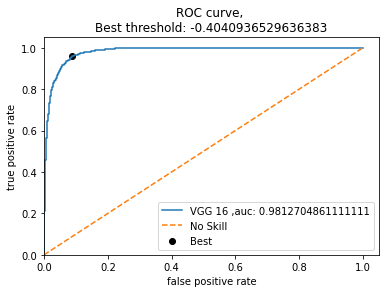

In [6]:
history_vgg_16, model_vgg_16 = create_and_train_model(tf.keras.applications.vgg16.VGG16(include_top=False), 128, 10, "VGG 16")

# VGG 19

Epoch 1/10
94/94 [==============================] - 46s 482ms/step - loss: 0.0375 - val_loss: 0.0257
Epoch 2/10
94/94 [==============================] - 45s 481ms/step - loss: 0.0215 - val_loss: 0.0181
Epoch 3/10
94/94 [==============================] - 45s 479ms/step - loss: 0.0215 - val_loss: 0.0204
Epoch 4/10
94/94 [==============================] - 45s 480ms/step - loss: 0.0196 - val_loss: 0.0172
Epoch 5/10
94/94 [==============================] - 45s 480ms/step - loss: 0.0163 - val_loss: 0.0171
Epoch 6/10
94/94 [==============================] - 45s 480ms/step - loss: 0.0153 - val_loss: 0.0184
Epoch 7/10
94/94 [==============================] - 45s 480ms/step - loss: 0.0140 - val_loss: 0.0162
Epoch 8/10
94/94 [==============================] - 45s 480ms/step - loss: 0.0130 - val_loss: 0.0152
Epoch 9/10
94/94 [==============================] - 45s 480ms/step - loss: 0.0128 - val_loss: 0.0156
Epoch 10/10
94/94 [==============================] - 45s 480ms/step - loss: 0.0128 - val_lo

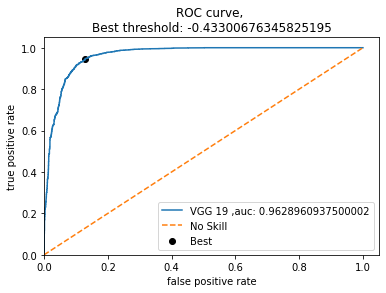

In [80]:
history_vgg_19, model_vgg_19 = create_and_train_model(tf.keras.applications.vgg19.VGG19(include_top=False), 128, 10, "VGG 19")

# Resnet 101 V2

Epoch 1/10
94/94 [==============================] - 60s 543ms/step - loss: 0.0327 - val_loss: 0.0197
Epoch 2/10
94/94 [==============================] - 49s 514ms/step - loss: 0.0134 - val_loss: 0.0172
Epoch 3/10
94/94 [==============================] - 48s 513ms/step - loss: 0.0076 - val_loss: 0.0204
Epoch 4/10
94/94 [==============================] - 48s 513ms/step - loss: 0.0055 - val_loss: 0.0165
Epoch 5/10
94/94 [==============================] - 48s 513ms/step - loss: 0.0035 - val_loss: 0.0177
Epoch 6/10
94/94 [==============================] - 49s 514ms/step - loss: 0.0026 - val_loss: 0.0155
Epoch 7/10
94/94 [==============================] - 49s 514ms/step - loss: 0.0019 - val_loss: 0.0162
Epoch 8/10
94/94 [==============================] - 48s 513ms/step - loss: 0.0016 - val_loss: 0.0141
Epoch 9/10
94/94 [==============================] - 48s 513ms/step - loss: 0.0013 - val_loss: 0.0150
Epoch 10/10
94/94 [==============================] - 48s 513ms/step - loss: 0.0011 - val_lo

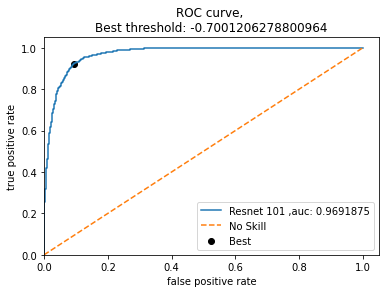

In [81]:
history_resnet_101_v2, model_resnet_101_v2 = create_and_train_model(tf.keras.applications.resnet_v2.ResNet101V2(include_top=False), 128, 10, "Resnet 101")

# Inception ResNet V2

Epoch 1/10
94/94 [==============================] - 77s 622ms/step - loss: 0.0425 - val_loss: 0.0333
Epoch 2/10
94/94 [==============================] - 52s 551ms/step - loss: 0.0240 - val_loss: 0.0221
Epoch 3/10
94/94 [==============================] - 52s 553ms/step - loss: 0.0203 - val_loss: 0.0215
Epoch 4/10
94/94 [==============================] - 52s 552ms/step - loss: 0.0166 - val_loss: 0.0225
Epoch 5/10
94/94 [==============================] - 52s 552ms/step - loss: 0.0142 - val_loss: 0.0175
Epoch 6/10
94/94 [==============================] - 52s 552ms/step - loss: 0.0118 - val_loss: 0.0196
Epoch 7/10
94/94 [==============================] - 52s 552ms/step - loss: 0.0105 - val_loss: 0.0200
Epoch 8/10
94/94 [==============================] - 52s 553ms/step - loss: 0.0097 - val_loss: 0.0183
Epoch 9/10
94/94 [==============================] - 52s 552ms/step - loss: 0.0087 - val_loss: 0.0162
Epoch 10/10
94/94 [==============================] - 52s 552ms/step - loss: 0.0084 - val_lo

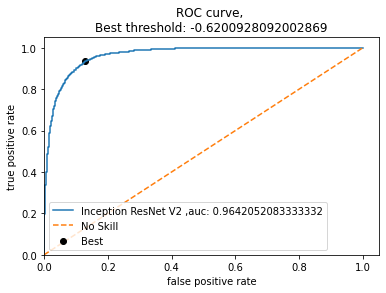

In [82]:
history_inception_resnet_v2, model_inception_resnet_v2 = create_and_train_model(tf.keras.applications.InceptionResNetV2(include_top=False), 128, 10, "Inception ResNet V2")

# Xception

Epoch 1/10
94/94 [==============================] - 46s 425ms/step - loss: 0.0433 - val_loss: 0.0377
Epoch 2/10
94/94 [==============================] - 37s 394ms/step - loss: 0.0230 - val_loss: 0.0308
Epoch 3/10
94/94 [==============================] - 37s 393ms/step - loss: 0.0163 - val_loss: 0.0273
Epoch 4/10
94/94 [==============================] - 37s 393ms/step - loss: 0.0114 - val_loss: 0.0291
Epoch 5/10
94/94 [==============================] - 37s 393ms/step - loss: 0.0089 - val_loss: 0.0254
Epoch 6/10
94/94 [==============================] - 37s 393ms/step - loss: 0.0069 - val_loss: 0.0257
Epoch 7/10
94/94 [==============================] - 37s 394ms/step - loss: 0.0061 - val_loss: 0.0241
Epoch 8/10
94/94 [==============================] - 37s 394ms/step - loss: 0.0044 - val_loss: 0.0261
Epoch 9/10
94/94 [==============================] - 37s 394ms/step - loss: 0.0042 - val_loss: 0.0250
Epoch 10/10
94/94 [==============================] - 37s 393ms/step - loss: 0.0028 - val_lo

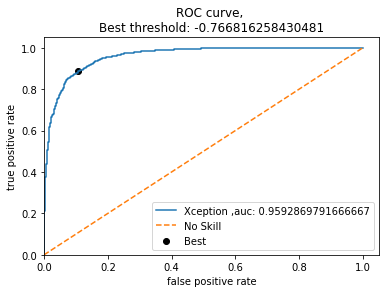

In [84]:
history_xception, model_xception = create_and_train_model(tf.keras.applications.xception.Xception(include_top=False), 128, 10, "Xception")

# Inception V3

Epoch 1/10
94/94 [==============================] - 36s 297ms/step - loss: 0.0505 - val_loss: 0.0396
Epoch 2/10
94/94 [==============================] - 25s 266ms/step - loss: 0.0289 - val_loss: 0.0342
Epoch 3/10
94/94 [==============================] - 25s 264ms/step - loss: 0.0217 - val_loss: 0.0357
Epoch 4/10
94/94 [==============================] - 25s 264ms/step - loss: 0.0178 - val_loss: 0.0363
Epoch 5/10
94/94 [==============================] - 25s 264ms/step - loss: 0.0147 - val_loss: 0.0317
Epoch 6/10
94/94 [==============================] - 25s 264ms/step - loss: 0.0111 - val_loss: 0.0340
Epoch 7/10
94/94 [==============================] - 25s 265ms/step - loss: 0.0101 - val_loss: 0.0303
Epoch 8/10
94/94 [==============================] - 25s 264ms/step - loss: 0.0088 - val_loss: 0.0326
Epoch 9/10
94/94 [==============================] - 25s 264ms/step - loss: 0.0069 - val_loss: 0.0338
Epoch 10/10
94/94 [==============================] - 25s 264ms/step - loss: 0.0062 - val_lo

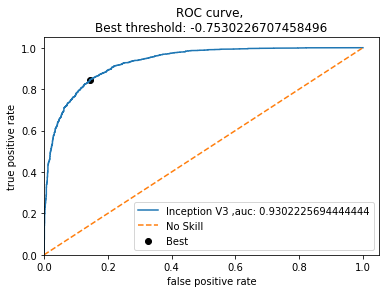

In [85]:
history_inception_v3, model_inception_v3 = create_and_train_model(tf.keras.applications.inception_v3.InceptionV3(include_top=False), 128, 10, "Inception V3")

In [143]:
results = model_vgg_16.predict(test_dataset)
emb_size = 128

In [45]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
tsne = TSNE(n_components=2, n_iter=15000, metric="cosine")

In [ ]:
emb_list = []
for i in range(10):
    anchor = results[i][:emb_size]
    positive = results[i][emb_size:emb_size*2]
    negative = results[i][emb_size*2:]
    cache_list = []
    anchor_emb = tsne.fit_transform(anchor.reshape(-1,1))
    positive_emb = tsne.fit_transform(positive.reshape(-1,1))
    negative_emb = tsne.fit_transform(negative.reshape(-1,1))
    cache_list.append(anchor_emb)
    cache_list.append(positive_emb)
    cache_list.append(negative_emb)
    
    emb_list.append(cache_list)

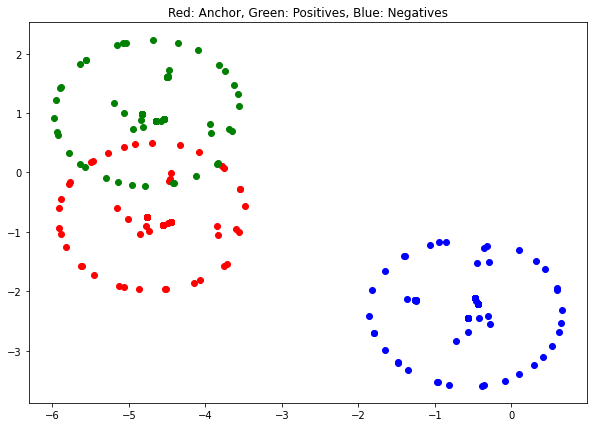

In [150]:
plt.figure(figsize=(10,7))
for i in range(1):
    plt.scatter(emb_list[i][0][:,0], emb_list[i][0][:,1], color="red")
    plt.scatter(emb_list[i][1][:,0], emb_list[i][1][:,1], color="green")
    plt.scatter(emb_list[i][2][:,0], emb_list[i][2][:,1], color="blue")
    plt.title("Red: Anchor, Green: Positives, Blue: Negatives")

In [ ]:
#ToDO
#Visualize embeddings per scribe class
#Define e.g. 10 Scribes - and plot 1 vs scribe 2, 1 vs scribe 3, 1 vs scribe 4...

In [22]:
from helper_functions import resize_and_keep_ratio, crop_image
from paths import dataset_paths
import matplotlib.pyplot as plt

In [35]:
height, width = 224, 224

In [77]:
folder_1, folder_2, folder_3 = random.sample(dataset_paths, 3)

In [78]:
folder_list_1 = []
folder_list_1.append(folder_1)
folder_list_2 = []
folder_list_2.append(folder_2)
folder_list_3 = []
folder_list_3.append(folder_3)

In [79]:
img_1 = resize_and_keep_ratio(folder_list_1, height, rgb=True)
img_2 = resize_and_keep_ratio(folder_list_2, height, rgb=True)
img_3 = resize_and_keep_ratio(folder_list_3, height, rgb=True)

In [80]:
img_1 = crop_image(img_1, width) / 255.
img_2 = crop_image(img_2, width) / 255.
img_3 = crop_image(img_3, width) / 255.

In [81]:
img_1 = np.expand_dims(img_1, 0)
img_2 = np.expand_dims(img_2, 0)
img_3 = np.expand_dims(img_3, 0)

In [82]:
results = model_vgg_16.predict([img_1, img_2, img_3])

In [83]:
emb_size = 128
anchor = results[0][:emb_size]
positive = results[0][emb_size:emb_size*2]
negative = results[0][emb_size*2:]

In [84]:
anchor_emb = tsne.fit_transform(anchor.reshape(-1,1))
positive_emb = tsne.fit_transform(positive.reshape(-1,1))
negative_emb = tsne.fit_transform(negative.reshape(-1,1))

/home/js/.local/lib/python3.6/site-packages/sklearn/manifold/_t_sne.py:699: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  FutureWarning
/home/js/.local/lib/python3.6/site-packages/sklearn/manifold/_t_sne.py:699: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  FutureWarning
/home/js/.local/lib/python3.6/site-packages/sklearn/manifold/_t_sne.py:699: Fu

Text(0.5, 1.0, 'Red: Anchor, Green: Positives, Blue: Negatives')

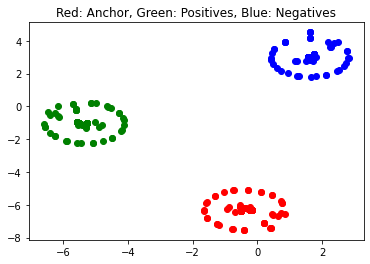

In [85]:
plt.scatter(anchor_emb[:,0], anchor_emb[:,1], color="red")
plt.scatter(positive_emb[:,0], positive_emb[:,1], color="green")
plt.scatter(negative_emb[:,0], negative_emb[:,1], color="blue")
plt.title("Red: Anchor, Green: Positives, Blue: Negatives")